# SHAP Analysis

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path

# Detect project root (parent of notebooks/)
ROOT = Path.cwd().parents[0]

# Add root to path if not present
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Define paths used in the pipeline
DATA_TRAIN   = ROOT / "data" / "interim" / "training_fe.csv"
DATA_LABELS  = ROOT / "data" / "raw" / "training_set_labels.csv"
DATA_TEST    = ROOT / "data" / "interim" / "test_fe.csv"

ARTIFACTS    = ROOT / "artifacts"

In [3]:
from src.modeling import load_final_models
models = load_final_models(str(ARTIFACTS))

In [6]:
from src.modeling import load_training_data

# Load Data (Need features to calculate SHAP values)
X, _ = load_training_data(DATA_TRAIN, DATA_LABELS)

In [ ]:
def plot_shap_importance(models, X_data):
    """
    Calculates and plots SHAP values for the given models, and returns tables with SHAP importance.
    
    Args:
        models: Dictionary of trained models
        X_data: Feature data (DataFrame or array)
    
    Returns:
        dict: Dictionary containing SHAP importance DataFrames for each model
    """
    # Initialize JS visualization code (if running in a notebook environment)
    shap.initjs()
    
    shap_tables = {}
    
    for target, model in models.items():
        print(f"\n=== SHAP Analysis for {target} ===")
        
        # Create TreeExplainer
        explainer = shap.TreeExplainer(model)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_data)
        
        # For binary classification, shap_values is often a list: [class_0_values, class_1_values]
        # We are interested in class 1 (the positive case: received vaccine)
        if isinstance(shap_values, list):
            vals = shap_values[1]
        else:
            vals = shap_values
            
        # 1. Summary Plot (Beeswarm)
        # Shows feature importance ranking AND how feature values impact the output
        plt.figure()
        plt.title(f"SHAP Summary: {target}")
        shap.summary_plot(vals, X_data, show=False)
        plt.tight_layout()
        plt.show()
        
        # 2. Bar Plot (Mean absolute SHAP value)
        # Simpler view, strictly for ranking importance magnitude
        plt.figure()
        plt.title(f"SHAP Feature Importance (Mean Abs): {target}")
        shap.summary_plot(vals, X_data, plot_type="bar", show=False)
        plt.tight_layout()
        plt.show()
        
        # 3. Create SHAP importance table
        # Calculate mean absolute SHAP values for each feature
        feature_names = X_data.columns if isinstance(X_data, pd.DataFrame) else [f"Feature_{i}" for i in range(X_data.shape[1])]
        mean_abs_shap = pd.DataFrame({
            'Feature': feature_names,
            'Mean_Absolute_SHAP': np.abs(vals).mean(axis=0)
        })
        mean_abs_shap = mean_abs_shap.sort_values('Mean_Absolute_SHAP', ascending=False).reset_index(drop=True)
        mean_abs_shap['Rank'] = range(1, len(mean_abs_shap) + 1)
        mean_abs_shap = mean_abs_shap[['Rank', 'Feature', 'Mean_Absolute_SHAP']]
        
        # Store in dictionary
        shap_tables[target] = mean_abs_shap
        
        # Display the table
        print(f"\n{target} - SHAP Feature Importance Table:")
        print(mean_abs_shap.to_string(index=False))
        print("\n" + "="*80)
    
    return shap_tables


=== SHAP Analysis for h1n1_vaccine ===


c:\Projects\Flushot\.venv\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


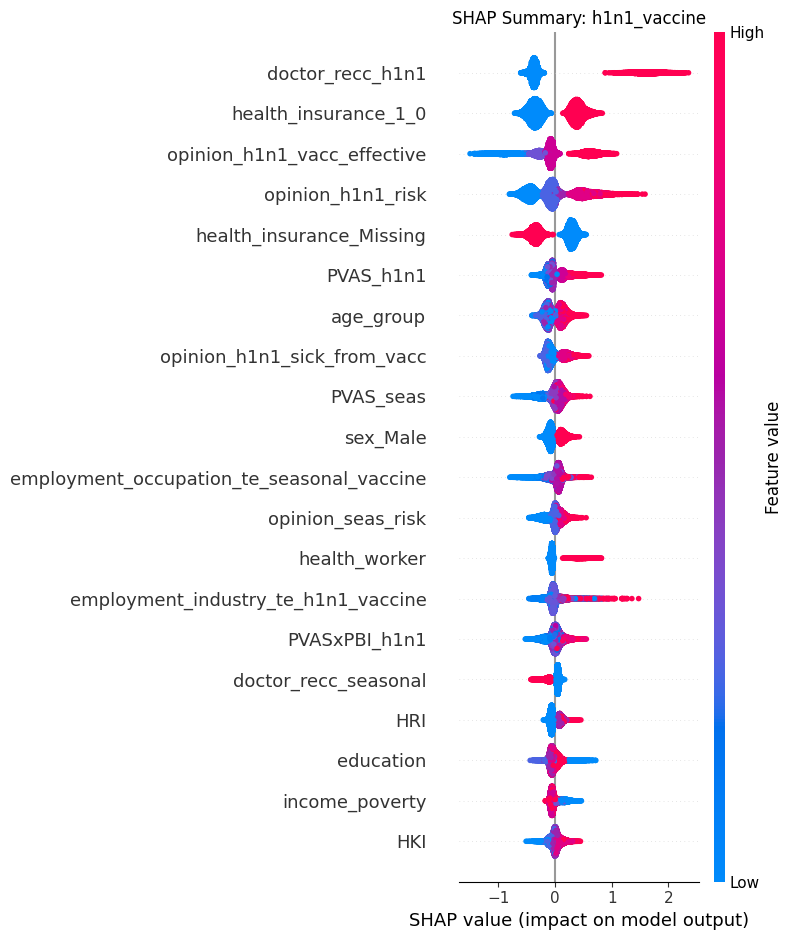

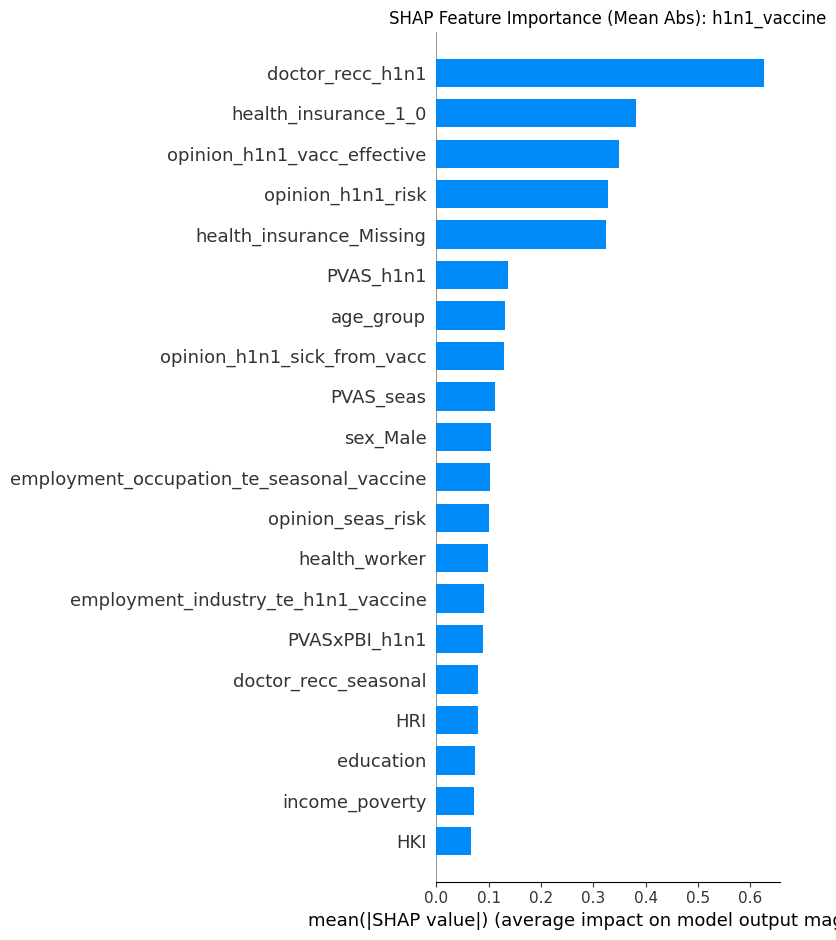


h1n1_vaccine - SHAP Feature Importance Table:
 Rank                                   Feature  Mean_Absolute_SHAP
    1                          doctor_recc_h1n1            0.625250
    2                      health_insurance_1_0            0.381674
    3               opinion_h1n1_vacc_effective            0.348122
    4                         opinion_h1n1_risk            0.328079
    5                  health_insurance_Missing            0.324273
    6                                 PVAS_h1n1            0.137238
    7                                 age_group            0.131140
    8               opinion_h1n1_sick_from_vacc            0.129946
    9                                 PVAS_seas            0.113161
   10                                  sex_Male            0.103763
   11 employment_occupation_te_seasonal_vaccine            0.101835
   12                         opinion_seas_risk            0.101116
   13                             health_worker            0.099669
 

c:\Projects\Flushot\.venv\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


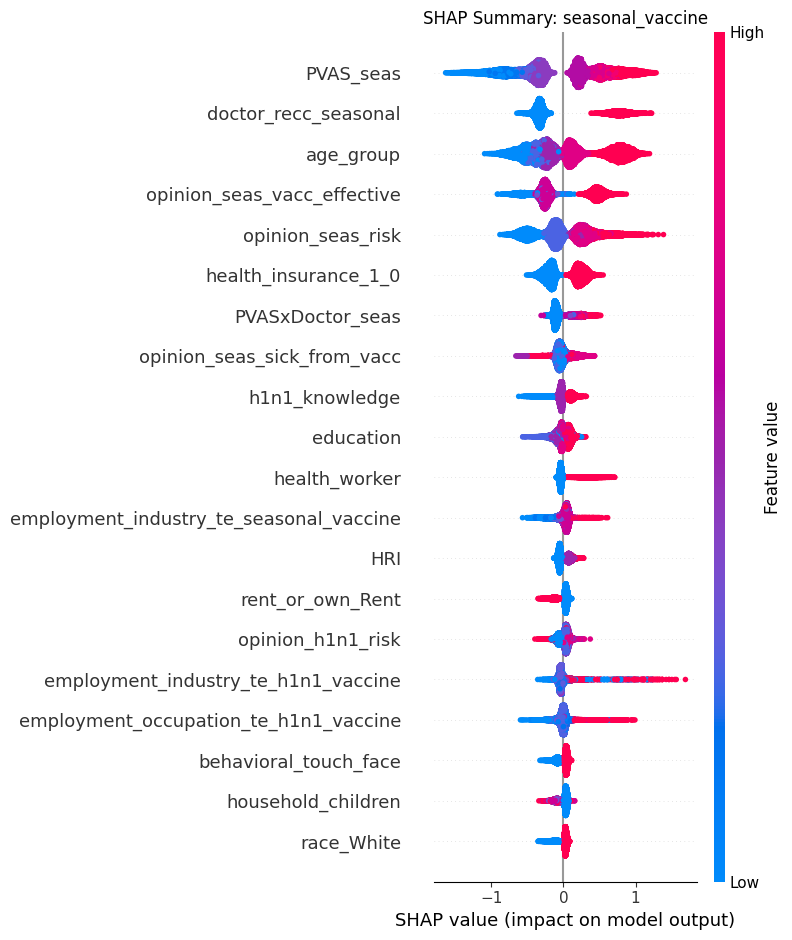

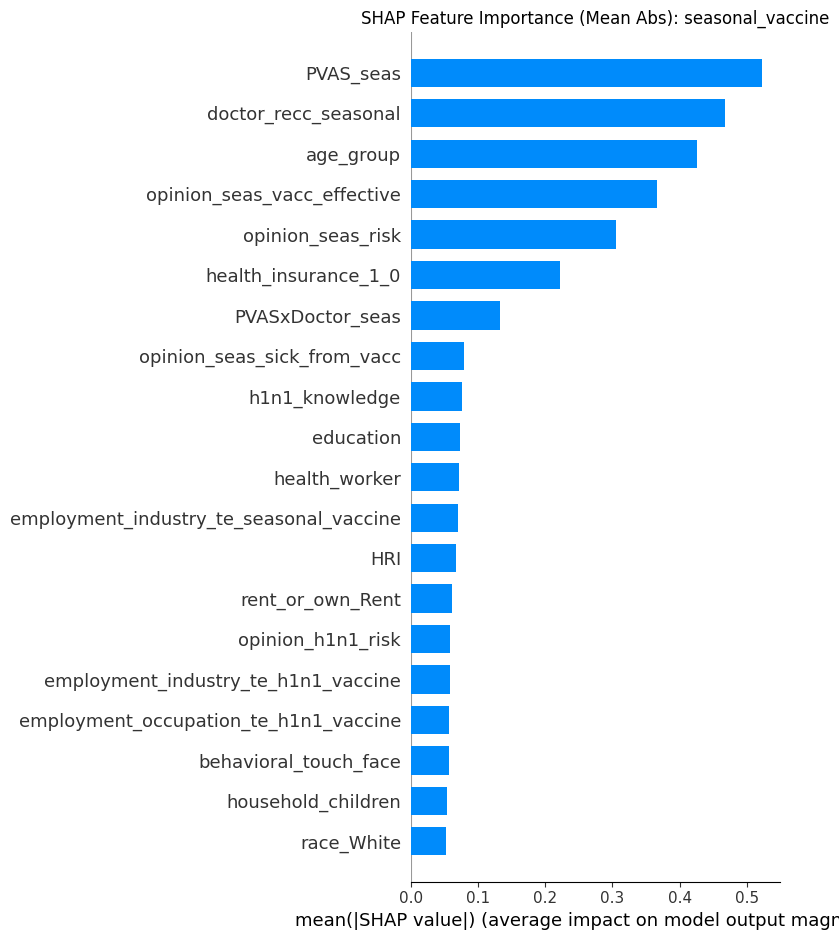


seasonal_vaccine - SHAP Feature Importance Table:
 Rank                                   Feature  Mean_Absolute_SHAP
    1                                 PVAS_seas            0.523153
    2                      doctor_recc_seasonal            0.467807
    3                                 age_group            0.426149
    4               opinion_seas_vacc_effective            0.367014
    5                         opinion_seas_risk            0.305042
    6                      health_insurance_1_0            0.222689
    7                          PVASxDoctor_seas            0.133534
    8               opinion_seas_sick_from_vacc            0.079111
    9                            h1n1_knowledge            0.075655
   10                                 education            0.073796
   11                             health_worker            0.071713
   12   employment_industry_te_seasonal_vaccine            0.070662
   13                                       HRI            0.0669

In [17]:
# Run the analysis and get tables
shap_importance_tables = plot_shap_importance(models, X)

In [18]:
# Access individual tables
h1n1_table = shap_importance_tables['h1n1_vaccine']
seasonal_table = shap_importance_tables['seasonal_vaccine']

In [ ]:
# Save to CSV
h1n1_table.to_csv('../artifacts/h1n1_shap_importance.csv', index=False)
seasonal_table.to_csv('../artifacts/seasonal_shap_importance.csv', index=False)

## SHAP Insights & Feature Engineering Impact

### Key Takeaways - H1N1 Model

#### 1. **Doctor recommendation dominates**

The single strongest predictor is:

* `doctor_recc_h1n1` - SHAP ≈ **0.63**

This dwarfs most features - meaning physician recommendation is the most decisive input for H1N1 vaccination prediction.

#### 2. **Original opinion-level attitudes are more important than engineered aggregates**

The original raw opinion variables:

* `opinion_h1n1_vacc_effective`
* `opinion_h1n1_risk`
* `opinion_h1n1_sick_from_vacc`

…rank **above** the engineered:

* `PVAS_h1n1`

This indicates that **compressing these opinions into a composite loses signal** - the model is able to use the individual components more effectively.

#### 3. **Health insurance matters strongly**

Both:

* `health_insurance_1_0`
* `health_insurance_Missing`

…rank extremely high - showing that access to coverage influences vaccination behavior significantly.

#### 4. **Engineered interaction features provided limited value**

Several interaction features have **zero SHAP contribution**, including:

* `SeniorxChronic`
* `PovertyxRent`
* `PBIxNoInsur`
* `doctor_any` (nearly zero)
* `below_poverty`, `is_senior`, etc.

This suggests either:

* the model captures the interaction implicitly, or
* the interaction effect is simply weak.

#### 5. **Socio-demographic features have small but non-zero signal**

* `age_group`
* `education`
* `income_poverty`
* `race_X`
* `msa_region`

They rank mid-pack - useful but not core.

---

###  Key Takeaways - Seasonal Vaccine Model

#### 1. **Attitude is king**

The strongest predictor is:

* `PVAS_seas` - SHAP ≈ **0.52**

Unlike H1N1, the engineered composite score **is more predictive than the individual opinion pieces**.

#### 2. **Doctor recommendation remains critical**

* `doctor_recc_seasonal` - SHAP ≈ **0.47**

Nearly as influential as PVAS.

#### 3. **Age is unexpectedly powerful**

* `age_group` - SHAP ≈ **0.43**

Age plays a larger role in seasonal vaccination than H1N1.

#### 4. **Engineered interactions show real value**

For the seasonal model:

* `PVASxDoctor_seas` - SHAP ≈ **0.13**

This confirms:

> When attitude & doctor advice align, vaccination likelihood drastically increases.

#### 5. **Socio-economic features are meaningful but secondary**

* `health_worker`
* `education`
* `rent_or_own_Rent`
* `employment_industry_te_*`

They shape general probability but are not central.

---

## Original vs Engineered Feature Value

| Feature Type                      | H1N1             | Seasonal                 | Interpretation                                    |
| --------------------------------- | ---------------- | ------------------------ | ------------------------------------------------- |
| **Raw attitude features**         | Strong           | Moderate                 | Individual components matter more for H1N1        |
| **PVAS attitude composites**      | Medium           | Very strong              | Better abstraction of opinion for Seasonal        |
| **Health Insurance flags**        | Strong           | Strong                   | Consistent structural predictor                   |
| **Doctor recommendation**         | Very strong      | Very strong              | Key driver for both vaccines                      |
| **HRI & HKI indices**             | Low-Medium       | Low-Medium               | Not dominant features                             |
| **Interaction features**          | Minimal / unused | One strong (PVASxDoctor) | Interaction effects only useful in seasonal model |
| **Occupation-industry encodings** | Medium           | Medium                   | Job-environment matters for both                  |

---

## Recommended Feature Reduction for Deployment

When moving to Streamlit, you want a smaller, faster model with minimal cognitive overhead.

---

### Recommended H1N1 Feature Subset

**Keep these:**

* `doctor_recc_h1n1`
* `health_insurance_1_0`
* `opinion_h1n1_vacc_effective`
* `opinion_h1n1_risk`
* `opinion_h1n1_sick_from_vacc`
* `age_group`
* `sex`
* `health_worker`
* `employment_*_te_h1n1`
* `education`
* `income_poverty`

**Optionally keep:**

* `PVAS_h1n1` (adds minor value)
* `HRI` / `HKI` (small signal)

**Remove entirely:**

* all interaction features
* `below_poverty`, `is_senior`, `no_insurance`, etc. (zero SHAP)
* `PBI` and behavioral micro-features - low predictive power
* all `hhs_geo_region_*`

This could drop feature count by **40–50%** with negligible accuracy loss.

---

### Recommended Seasonal Model Feature Subset

**Keep these:**

* `PVAS_seas`
* `doctor_recc_seasonal`
* `age_group`
* `health_insurance_1_0`
* `opinion_seas_vacc_effective`
* `opinion_seas_risk`
* `PVASxDoctor_seas` (important!)
* `health_worker`
* `education`

**Optionally keep:**

* `employment_industry_te_*`
* `HKI`
* `PVAS_h1n1`

**Remove entirely:**

* most interaction features except `PVASxDoctor_seas`
* `below_poverty`, `low_edu`, etc. (zero SHAP)
* all weak behaviorals (wash_hands, avoid, touch_face, etc.)
* geographic one-hot regions

---

## Final Summary

#### • The models rely more on **attitudes and doctor recommendations** than demographic or behavioral traits.

#### • Engineered features were partially successful:

* PVAS scores: useful **especially for seasonal**
* Interaction features: only one adds real value
* Composite indices (HRI, HKI): mild contribution, not central.

#### • Many engineered features can be pruned - they add complexity without improving signal.

---

## Practical Deployment Advice (Streamlit)

* Limit user inputs to **10–14 high-value features**
* Use dropdowns for categorical features like age & occupation
* Let users visually see probability changes based on:

  * doctor recommendation
  * vaccine beliefs
  * risk perception